Pipeline

0. Get HR as correct signal from pyVHR
1. Extract spatial temporal map
2. Train
3. Eval
4. Predict

In [35]:
import os
from utils.dataset import DataLoaderRhythmNet
from utils.model_utils import plot_loss, load_model_if_checkpointed, save_model_checkpoint
from models.rhythmNet import RhythmNet
from loss_func.rhythmnet_loss import RhythmNetLoss
import torch
import config
from torch.utils.tensorboard import SummaryWriter

import utils.train_val as train_val
from utils.plot_scripts import plot_train_test_curves, bland_altman_plot, gt_vs_est, create_plot_for_tensorboard
import numpy as np

In [36]:
import importlib
importlib.reload(train_val)

<module 'utils.train_val' from 'c:\\Users\\andre\\OneDriveDTU\\Bachelorprojekt\\Heart-Rate-Estimation\\RhythmNet\\utils\\train_val.py'>

In [37]:
# check path to checkpoint directory
if config.CHECKPOINT_PATH:
    if not os.path.exists(config.CHECKPOINT_PATH):
        os.makedirs(config.CHECKPOINT_PATH)
        print("Output directory is created")

model = RhythmNet()

if torch.cuda.is_available():
    print('GPU available... using GPU')
    torch.cuda.manual_seed_all(42)
else:
    print("GPU not available, using CPU")

if config.CHECKPOINT_PATH:
    checkpoint_path = os.path.join(os.getcwd(), config.CHECKPOINT_PATH)
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
        print("Output directory is created")

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
)
# loss_fn = nn.L1Loss()
loss_fn = RhythmNetLoss()

testset = trainset = None

# Initialize SummaryWriter object
writer = SummaryWriter()

GPU not available, using CPU


In [38]:
# video files are st_maps
test_video_dir = '../data/st_maps/test'
train_video_dir = '../data/st_maps/train'
video_files_train = os.listdir("../data/st_maps/train/")
video_files_test = os.listdir("../data/st_maps/test/")
test_video_items = [test_video_dir+'/'+filename for filename in os.listdir(test_video_dir)] 
train_video_items = [train_video_dir+'/'+filename for filename in os.listdir(train_video_dir)] 
TARGET_SIGNAL_DIR = '../data/hr_data'
# --------------------------------------
# Build Dataloaders
# --------------------------------------
def collate_fn(batch):
    '''the collate function ensures that the maps of different sizes are stackable'''
    batched_st_map, batched_targets = [], []
    # for data in batch:
    #     batched_st_map.append(data["st_maps"])
    #     batched_targets.append(data["target"])
    # # torch.stack(batched_output_per_clip, dim=0).transpose_(0, 1)
    return batch

train_set = DataLoaderRhythmNet(st_maps_path=train_video_items, target_signal_path=TARGET_SIGNAL_DIR)
batch_size = 1
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    num_workers=0,
    shuffle=False,
    collate_fn=collate_fn
)
print('\nTrain DataLoader constructed successfully!')

# Code to use multiple GPUs (if available)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)


Train DataLoader constructed successfully!


In [39]:
# --------------------------------------
# Load checkpointed model (if  present)
# --------------------------------------
if device == "cpu":
    load_on_cpu = True
else:
    load_on_cpu = False
model, optimizer, checkpointed_loss, checkpoint_flag = load_model_if_checkpointed(model, optimizer, checkpoint_path, load_on_cpu=load_on_cpu)
if checkpoint_flag:
    print(f"Checkpoint Found! Loading from checkpoint :: LOSS={checkpointed_loss}")
else:
    print("Checkpoint Not Found! Training from beginning")

Checkpoint Not Found! Training from beginning


In [40]:
def rmse(l1, l2):
    return np.sqrt(np.mean((l1-l2)**2))

def mae(l1, l2):
    return np.mean([abs(item1-item2)for item1, item2 in zip(l1, l2)])

def compute_criteria(target_hr_list, predicted_hr_list):
    pearson_per_signal = []
    HR_MAE = mae(np.array(predicted_hr_list), np.array(target_hr_list))
    HR_RMSE = rmse(np.array(predicted_hr_list), np.array(target_hr_list))

    # for (gt_signal, predicted_signal) in zip(target_hr_list, predicted_hr_list):
    #     r, p_value = pearsonr(predicted_signal, gt_signal)
    #     pearson_per_signal.append(r)

    # return {"MAE": np.mean(HR_MAE), "RMSE": HR_RMSE, "Pearson": np.mean(pearson_per_signal)}
    return {"MAE": np.mean(HR_MAE), "RMSE": HR_RMSE}

In [41]:
# --------------------------------------
# Load checkpointed model (if  present)
# --------------------------------------
if config.DEVICE == "cpu":
    load_on_cpu = True
else:
    load_on_cpu = False
model, optimizer, checkpointed_loss, checkpoint_flag = load_model_if_checkpointed(model, optimizer,
                                                                                    checkpoint_path,
                                                                                    load_on_cpu=load_on_cpu)
if checkpoint_flag:
    print(f"Checkpoint Found! Loading from checkpoint :: LOSS={checkpointed_loss}")
    with open('../checkpoint/train_loss.pkl', "rb") as f:
        pickle.load(f)
else:
    print("Checkpoint Not Found! Training from beginning")


Checkpoint Not Found! Training from beginning


In [42]:
test_signal_path = ['../data/st_maps/test/']
test_set = DataLoaderRhythmNet(st_maps_path=test_video_items, target_signal_path=test_signal_path)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    num_workers=0,
    shuffle=False,
    collate_fn=collate_fn
)
print('\nEvaluation DataLoader constructed successfully!')


Evaluation DataLoader constructed successfully!


# Train

In [43]:
# Training
EPOCHS = 5
if not checkpoint_flag:
    train_losses = []
    train_loss_per_epoch = []
    eval_loss_per_epoch = []
    test_losses = []
    for epoch in range(EPOCHS):
        # short-circuit for evaluation
        
        target_hr_list, predicted_hr_list, train_loss = train_val.train_fn(model, train_loader, optimizer, loss_fn, batch_size=batch_size)
        train_losses.append(train_loss)
        # Save model with final train loss (script to save the best weights?)
        if checkpointed_loss != 0.0:
            if train_loss < checkpointed_loss:
                save_model_checkpoint(model, optimizer, train_loss, checkpoint_path)
                checkpointed_loss = train_loss
            else:
                pass
        else:
            if len(train_loss_per_epoch) > 0:
                if train_loss < min(train_loss_per_epoch):
                    save_model_checkpoint(model, optimizer, train_loss, checkpoint_path)
            else:
                save_model_checkpoint(model, optimizer, train_loss, checkpoint_path)

        metrics = compute_criteria(target_hr_list, predicted_hr_list)

        for metric in metrics.keys():
            writer.add_scalar(f"Train/{metric}", metrics[metric], epoch)

        print(f"\nFinished Train [Epoch: {epoch + 1}/{EPOCHS}]",
                "\nTraining Loss: {:.3f} |".format(train_loss),
                "HR_MAE : {:.3f} |".format(metrics["MAE"]),
                "HR_RMSE : {:.3f} |".format(metrics["RMSE"]),)
                # "Pearsonr : {:.3f} |".format(metrics["Pearson"]), )

        train_loss_per_epoch.append(train_loss)
        writer.add_scalar("Loss/train", train_loss, epoch+1)

        
        
        # validation
        target_hr_list, predicted_hr_list, test_loss = train_val.eval_fn(model, test_loader, loss_fn, batch_size=batch_size)
        test_losses.append(test_loss)
        # truth_hr_list.append(target)
        # estimated_hr_list.append(predicted)
        metrics = compute_criteria(target_hr_list, predicted_hr_list)
        for metric in metrics.keys():
            writer.add_scalar(f"Test/{metric}", metrics[metric], epoch)

        print(f"\nFinished Test [Epoch: {epoch + 1}/{EPOCHS}]",
                "\nTest Loss: {:.3f} |".format(test_loss),
                "HR_MAE : {:.3f} |".format(metrics["MAE"]),
                "HR_RMSE : {:.3f} |".format(metrics["RMSE"]),)

        writer.add_scalar("Loss/test", test_loss, epoch)

        # Plots on tensorboard
        # ba_plot_image = create_plot_for_tensorboard('bland_altman', target_hr_list, predicted_hr_list)
        # gtvsest_plot_image = create_plot_for_tensorboard('gt_vs_est', target_hr_list, predicted_hr_list)
        # writer.add_image('BA_plot', ba_plot_image, epoch)
        # writer.add_image('gtvsest_plot', gtvsest_plot_image, epoch)

    mean_loss = np.mean(train_loss_per_epoch)
    # Save the mean_loss value for each video instance to the writer
    print(f"Avg Training Loss: {np.mean(mean_loss)} for {EPOCHS} epochs")
    writer.flush()
    

100%|██████████| 16/16 [06:24<00:00, 24.06s/it]


Saved!

Finished [Epoch: 1/5] 
Training Loss: 54.978 | HR_MAE : 54.103 | HR_RMSE : 61.911 |


100%|██████████| 4/4 [00:18<00:00,  4.63s/it]



Finished Test [Epoch: 1/5] 
Test Loss: 19.462 | HR_MAE : 16.013 | HR_RMSE : 19.020 |


100%|██████████| 16/16 [06:39<00:00, 24.94s/it]


Saved!

Finished [Epoch: 2/5] 
Training Loss: 16.035 | HR_MAE : 15.062 | HR_RMSE : 19.651 |


100%|██████████| 4/4 [00:30<00:00,  7.64s/it]



Finished Test [Epoch: 2/5] 
Test Loss: 17.261 | HR_MAE : 15.900 | HR_RMSE : 23.558 |


100%|██████████| 16/16 [07:01<00:00, 26.36s/it]



Finished [Epoch: 3/5] 
Training Loss: 19.291 | HR_MAE : 18.700 | HR_RMSE : 23.761 |


100%|██████████| 4/4 [00:27<00:00,  6.84s/it]



Finished Test [Epoch: 3/5] 
Test Loss: 21.292 | HR_MAE : 20.810 | HR_RMSE : 22.818 |


100%|██████████| 16/16 [07:08<00:00, 26.75s/it]



Finished [Epoch: 4/5] 
Training Loss: 29.701 | HR_MAE : 29.391 | HR_RMSE : 32.520 |


100%|██████████| 4/4 [00:28<00:00,  7.19s/it]



Finished Test [Epoch: 4/5] 
Test Loss: 19.393 | HR_MAE : 18.785 | HR_RMSE : 26.675 |


100%|██████████| 16/16 [05:31<00:00, 20.71s/it]



Finished [Epoch: 5/5] 
Training Loss: 19.555 | HR_MAE : 19.020 | HR_RMSE : 23.428 |


100%|██████████| 4/4 [00:18<00:00,  4.75s/it]


Finished Test [Epoch: 5/5] 
Test Loss: 18.378 | HR_MAE : 17.903 | HR_RMSE : 25.691 |
Avg Training Loss: 27.91191910505295 for 5 epochs


In [44]:
import pickle
if not checkpoint_flag:
    with open('../checkpoint/train_loss.pkl', "wb") as f:
        pickle.dump(train_losses, f)
    with open('../checkpoint/test_loss.pkl', "wb") as f:
        pickle.dump(test_losses, f)
else:
    with open('../checkpoint/train_loss.pkl', "rb") as f:
        train_losses = pickle.load(f)
    with open('../checkpoint/test_losses.pkl', "rb") as f:
        test_losses = pickle.load(f)

# Test

Finished Training, Validating 4 video files for 1 Epochs


100%|██████████| 4/4 [00:18<00:00,  4.64s/it]



Finished Test [Epoch: 1/1] 
Test Loss: 18.378 | HR_MAE : 17.903 | HR_RMSE : 25.691 |
done


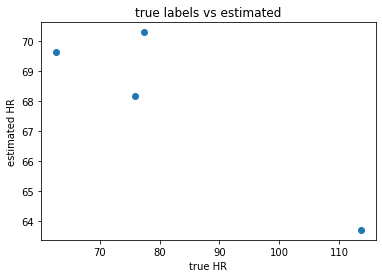

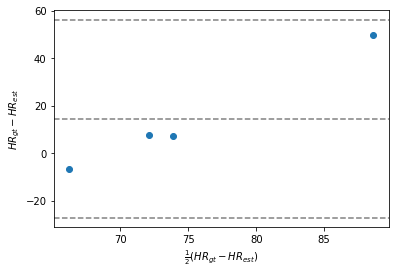

In [45]:
EPOCHS_TEST = 1
print(f"Finished Training, Validating {len(video_files_test)} video files for {EPOCHS_TEST} Epochs")

eval_loss_per_epoch = []
test_losses = []
for epoch in range(EPOCHS_TEST):
    # validation
    target_hr_list, predicted_hr_list, test_loss = train_val.eval_fn(model, test_loader, loss_fn, batch_size=batch_size)
    test_losses.append(test_loss)
    metrics = compute_criteria(target_hr_list, predicted_hr_list)

    print(f"\nFinished Test [Epoch: {epoch + 1}/{EPOCHS_TEST}]",
            "\nTest Loss: {:.3f} |".format(test_loss),
            "HR_MAE : {:.3f} |".format(metrics["MAE"]),
            "HR_RMSE : {:.3f} |".format(metrics["RMSE"]),)

# Plots on the local storage.
gt_vs_est(target_hr_list, predicted_hr_list, plot_path='plots')
bland_altman_plot(target_hr_list, predicted_hr_list, plot_path='plots')
writer.close()
print("done")

In [46]:
data = next(iter(test_loader))[0]
st_maps, target = data['st_maps'], data['target']
model.eval()
with torch.no_grad():
    pred = model(st_maps, target)

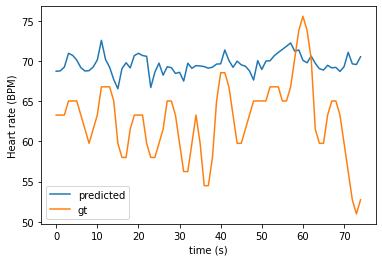

In [47]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = range(len(target))
ax.plot(pred[0].flatten(), label='predicted')
ax.plot(target, label='gt')
ax.set_xlabel('time (s)')
ax.set_ylabel('Heart rate (BPM)')
ax.legend();
plt.savefig('plots/predictedHR.pdf')

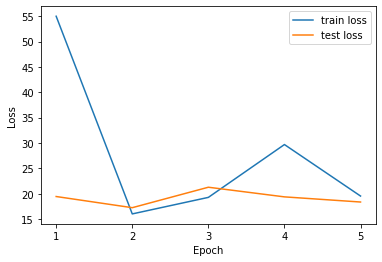

In [55]:
fig, ax = plt.subplots()
ax.plot(range(1,6), train_losses, label='train loss')
ax.plot(range(1,6), test_losses, label='test loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xticks(range(1,6))
ax.legend();
plt.savefig('plots/loss.pdf')